## Analyzing Distributions and Outliers

In this notebook, we will analyze the distributions of the features in the dataset and identify the outliers and anomalies to understand the data better. We will also remove some of the outliers to have a more clean dataset for later analysis.

First we load the data that we saved after preprocess part and take a look at the first few rows of the data and its columns.

In [141]:
import pandas as pd  

df = pd.read_csv('preprocessed_data.csv')

df.head()

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,rentZestimate,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView
0,90049,11645 Montana Ave APT 229,CONDO,1973,4645.390594,79.432065,1,1.0,1.0,"['Tile', 'Wood']",...,2999.0,"[('2022-08-12', 699000)]",3050,4,1,1,1,0,1,1
1,90066,4040 Grand View Blvd UNIT 15,TOWNHOUSE,1961,11561.886452,78.131423,2,1.5,1.0,['Other'],...,3997.0,"[('2015-10-21', 450000), ('2005-04-07', 396000)]",3100,0,1,1,0,0,0,0
2,91303,7305 Milwood Ave APT 3,CONDO,1981,90.301716,90.301716,2,1.0,1.0,[],...,3499.0,"[('2009-11-13', 85000), ('2007-04-18', 299000)...",2800,0,1,1,0,0,0,0
3,91040,8701 Hillrose St,SINGLE_FAMILY,1945,7098.170143,129.320976,2,1.5,1.0,[],...,3781.0,"[('2021-06-29', 3350), ('2019-01-22', 3150)]",3600,2,0,0,0,0,0,0
4,91325,17123 Roscoe Blvd UNIT 2,APARTMENT,1971,30031.677454,127.091304,3,2.0,1.0,[],...,3170.0,"[('2011-11-28', 140000), ('2011-09-16', 151300...",3100,2,1,1,1,0,0,0


In [142]:
df.columns

Index(['zipcode', 'streetAddress', 'homeType', 'yearBuilt', 'lotAreaValue',
       'livingAreaValue', 'bedrooms', 'bathrooms', 'stories', 'flooring',
       'heating', 'cooling', 'fireplaceFeatures', 'taxAssessedValue',
       'zestimate', 'rentZestimate', 'sold-history', 'price',
       'parkingCapacity', 'hasCooling', 'hasHeating', 'hasFireplace',
       'hasPrivatePool', 'hasSpa', 'hasView'],
      dtype='object')

### Distributions

One of the important thing in visualizing the distribution of data using histograms is to choose the number of bins. The number of bins can affect the shape of the histogram and the conclusions that we can draw from it. First we define some functions to calculate the number of bins using different methods:

 - `Sturges Rule`
   $$Number \ of \ Bins = 1 + \log_2(n)$$
   where n is size of data.

   This rule is based on the assumption that the data is normally distributed. It is a very simple rule and it is easy to implement. 

- `Scott's Rule`:
   $$Bin \ Width = \frac{3.5 \sigma}{n^{1/3}}$$
   Scott's rule is based on the normal distribution and is optimal for that distribution.
         
- `Freedman-Diaconis Rule`:
   $$Bin \ Width = 2 \frac{IQR(x)}{\sqrt[3]{n}}$$
   The Freedman-Diaconis rule is an attempt to generalize the Scott's rule to non-normal distributions. It is based on the interquartile range of the data.

In [143]:
def calc_num_of_bins_freedman_rule(data):
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    binwidth = 2 * iqr / (len(data) ** (1/3))
    num_bins = int((max(data) - min(data)) / binwidth)
    return num_bins
    
def calc_num_of_bins_scott_rule(data):
    num_bins = int((max(data) - min(data)) / (3.5 * np.std(data) / len(data) ** (1/3)))
    return num_bins

def calc_num_of_bins_sturges_rule(data):
    num_bins = int(np.log2(len(data)) + 1)
    return num_bins

def calc_binwidth(data, num_bins):
    binwidth = (max(data) - min(data)) / num_bins
    return binwidth

Now that we are ready to plot the histograms we choose some of the numerical features and plot their histograms:

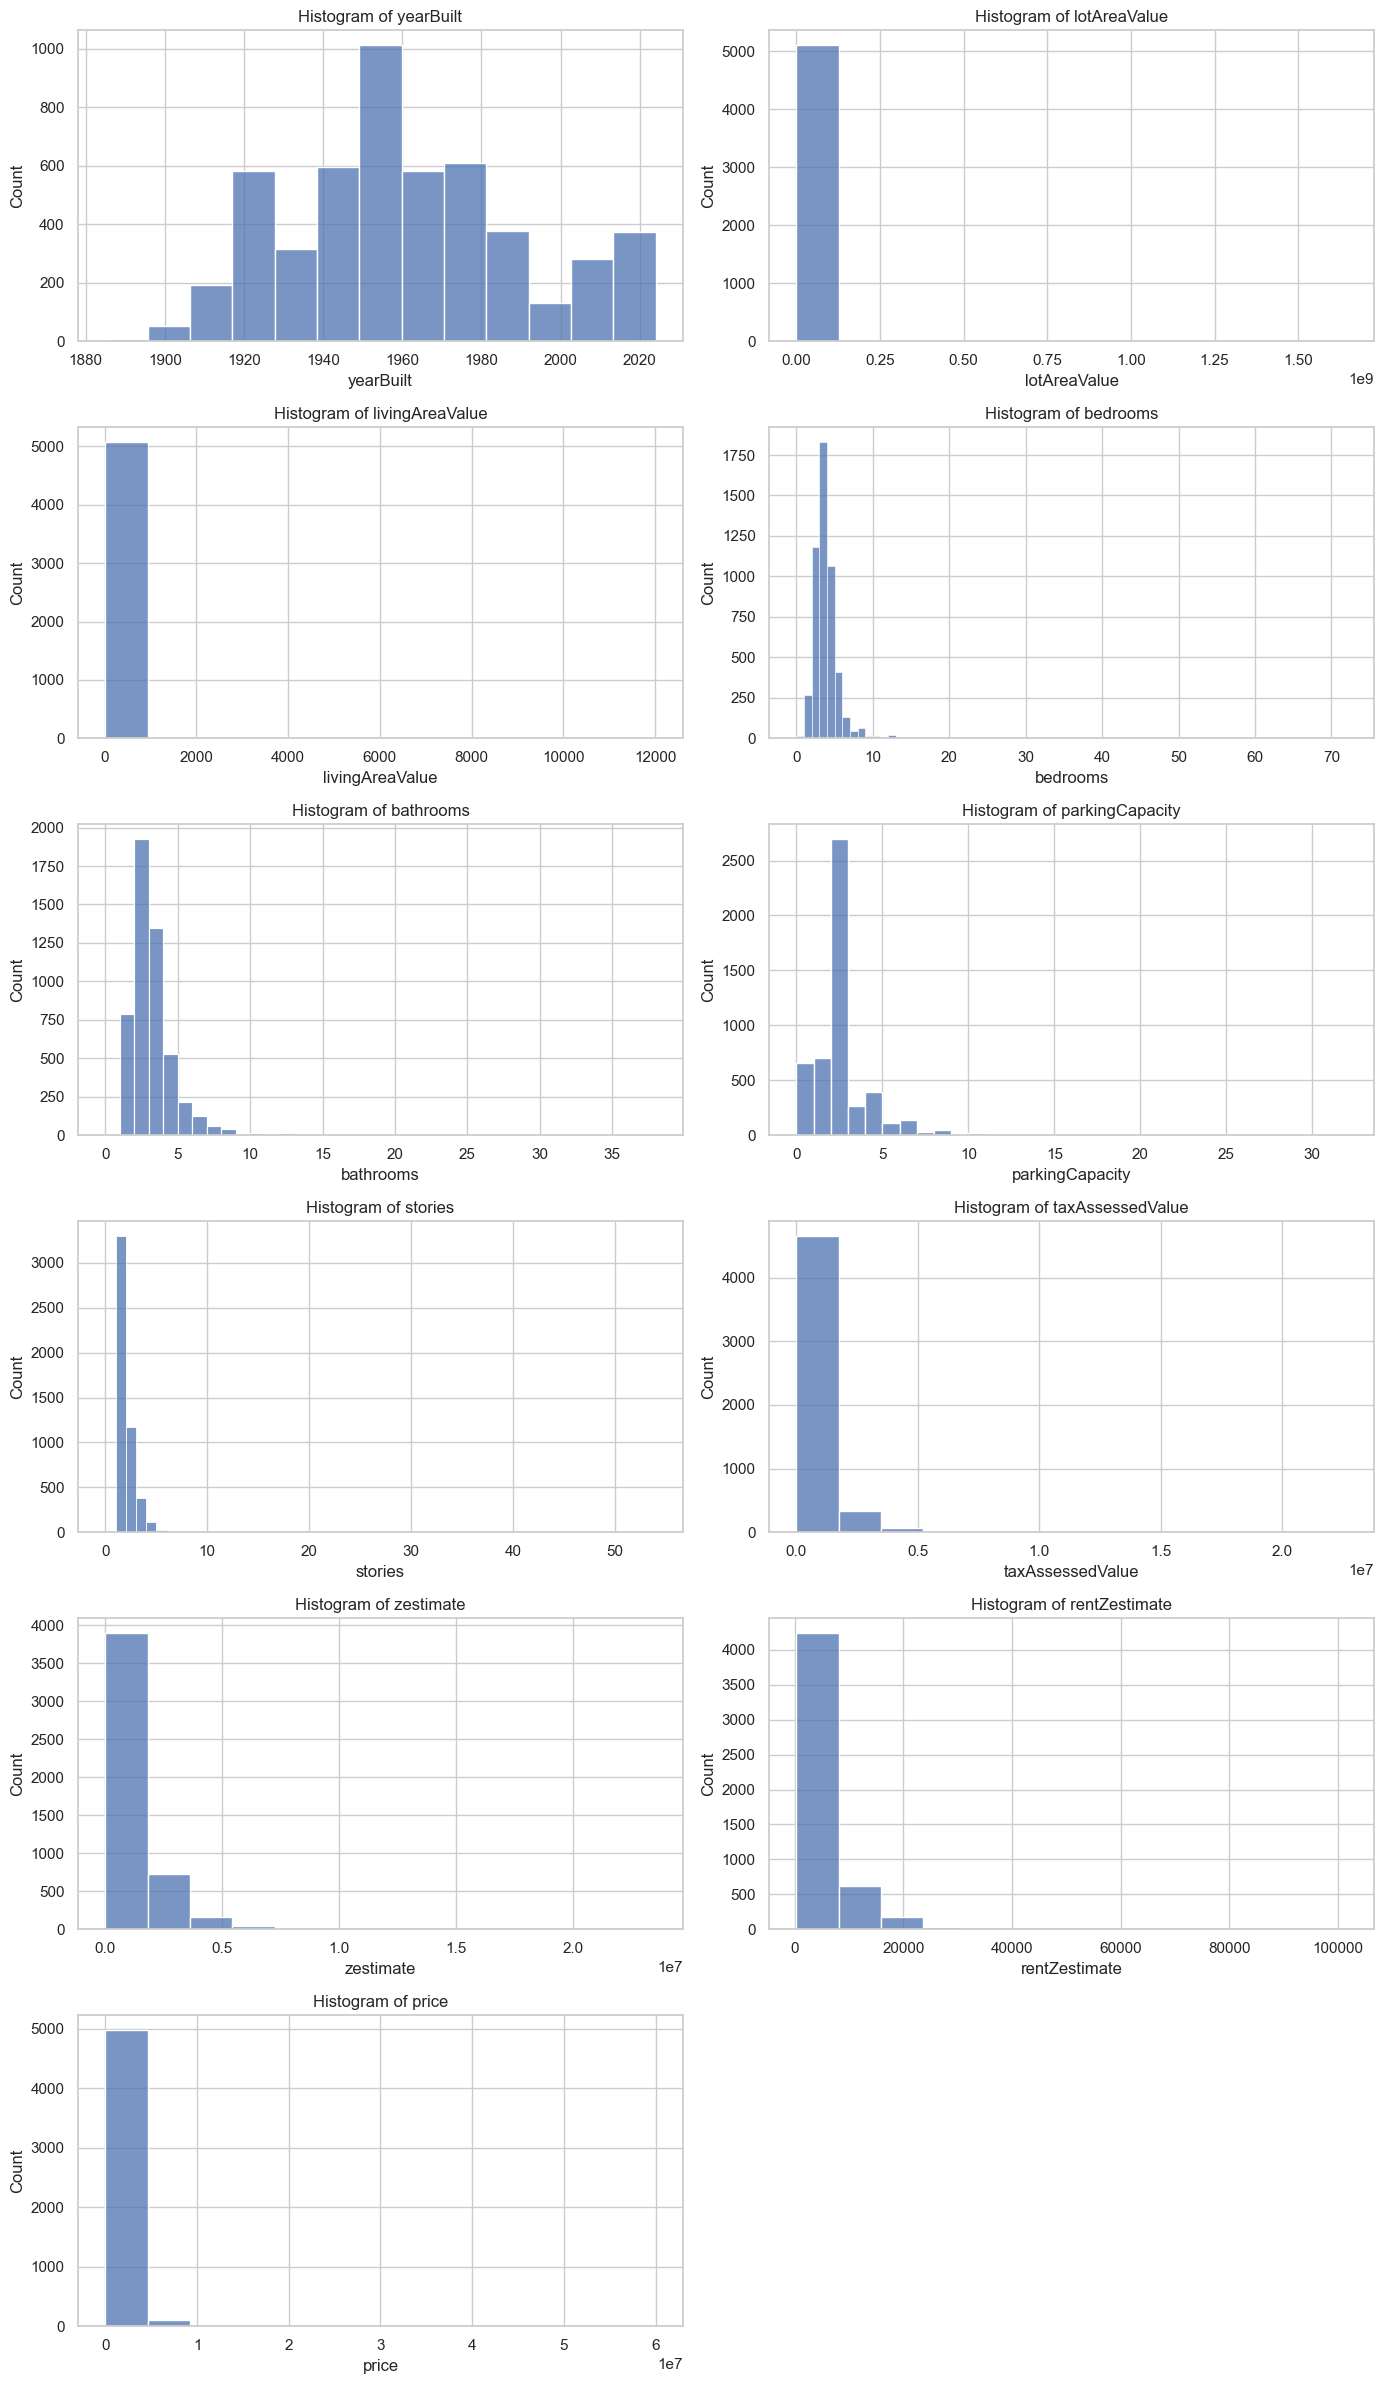

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math


features = ["yearBuilt", "lotAreaValue", "livingAreaValue", "bedrooms", "bathrooms", "parkingCapacity", "stories",
            "taxAssessedValue", "zestimate", "rentZestimate", "price"]

num_features = len(features)

num_cols = 2
num_rows = int(np.ceil(num_features / num_cols))

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7 * num_cols, 4 * num_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    if feature in ["bedrooms", "bathrooms", "stories", "parkingCapacity"]:
        bins = range(math.ceil(min(df[feature])), math.ceil(max(df[feature])) + 1)
        sns.histplot(df[feature], bins=bins, kde=False, ax=axes[i])
    else:
        sns.histplot(df[feature], bins=calc_num_of_bins_sturges_rule(df[feature]), kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

As you can see apart from `yearBuilt`, `bedrooms`, `bathrooms`, `parkingCapacity` and `stories` other features almost only have one bin and other bins are empty. This is probably because we have some significant outliers for those features and because of that other values go to one bin.

We also have outliers in `bedrooms`, `bathrooms`, `parkingCapacity` and `stories` but because we forced their bin width to be 1, we don't have the same problem for them.

We plot the boxplots of the features to visualize the significance of outliers in the data:

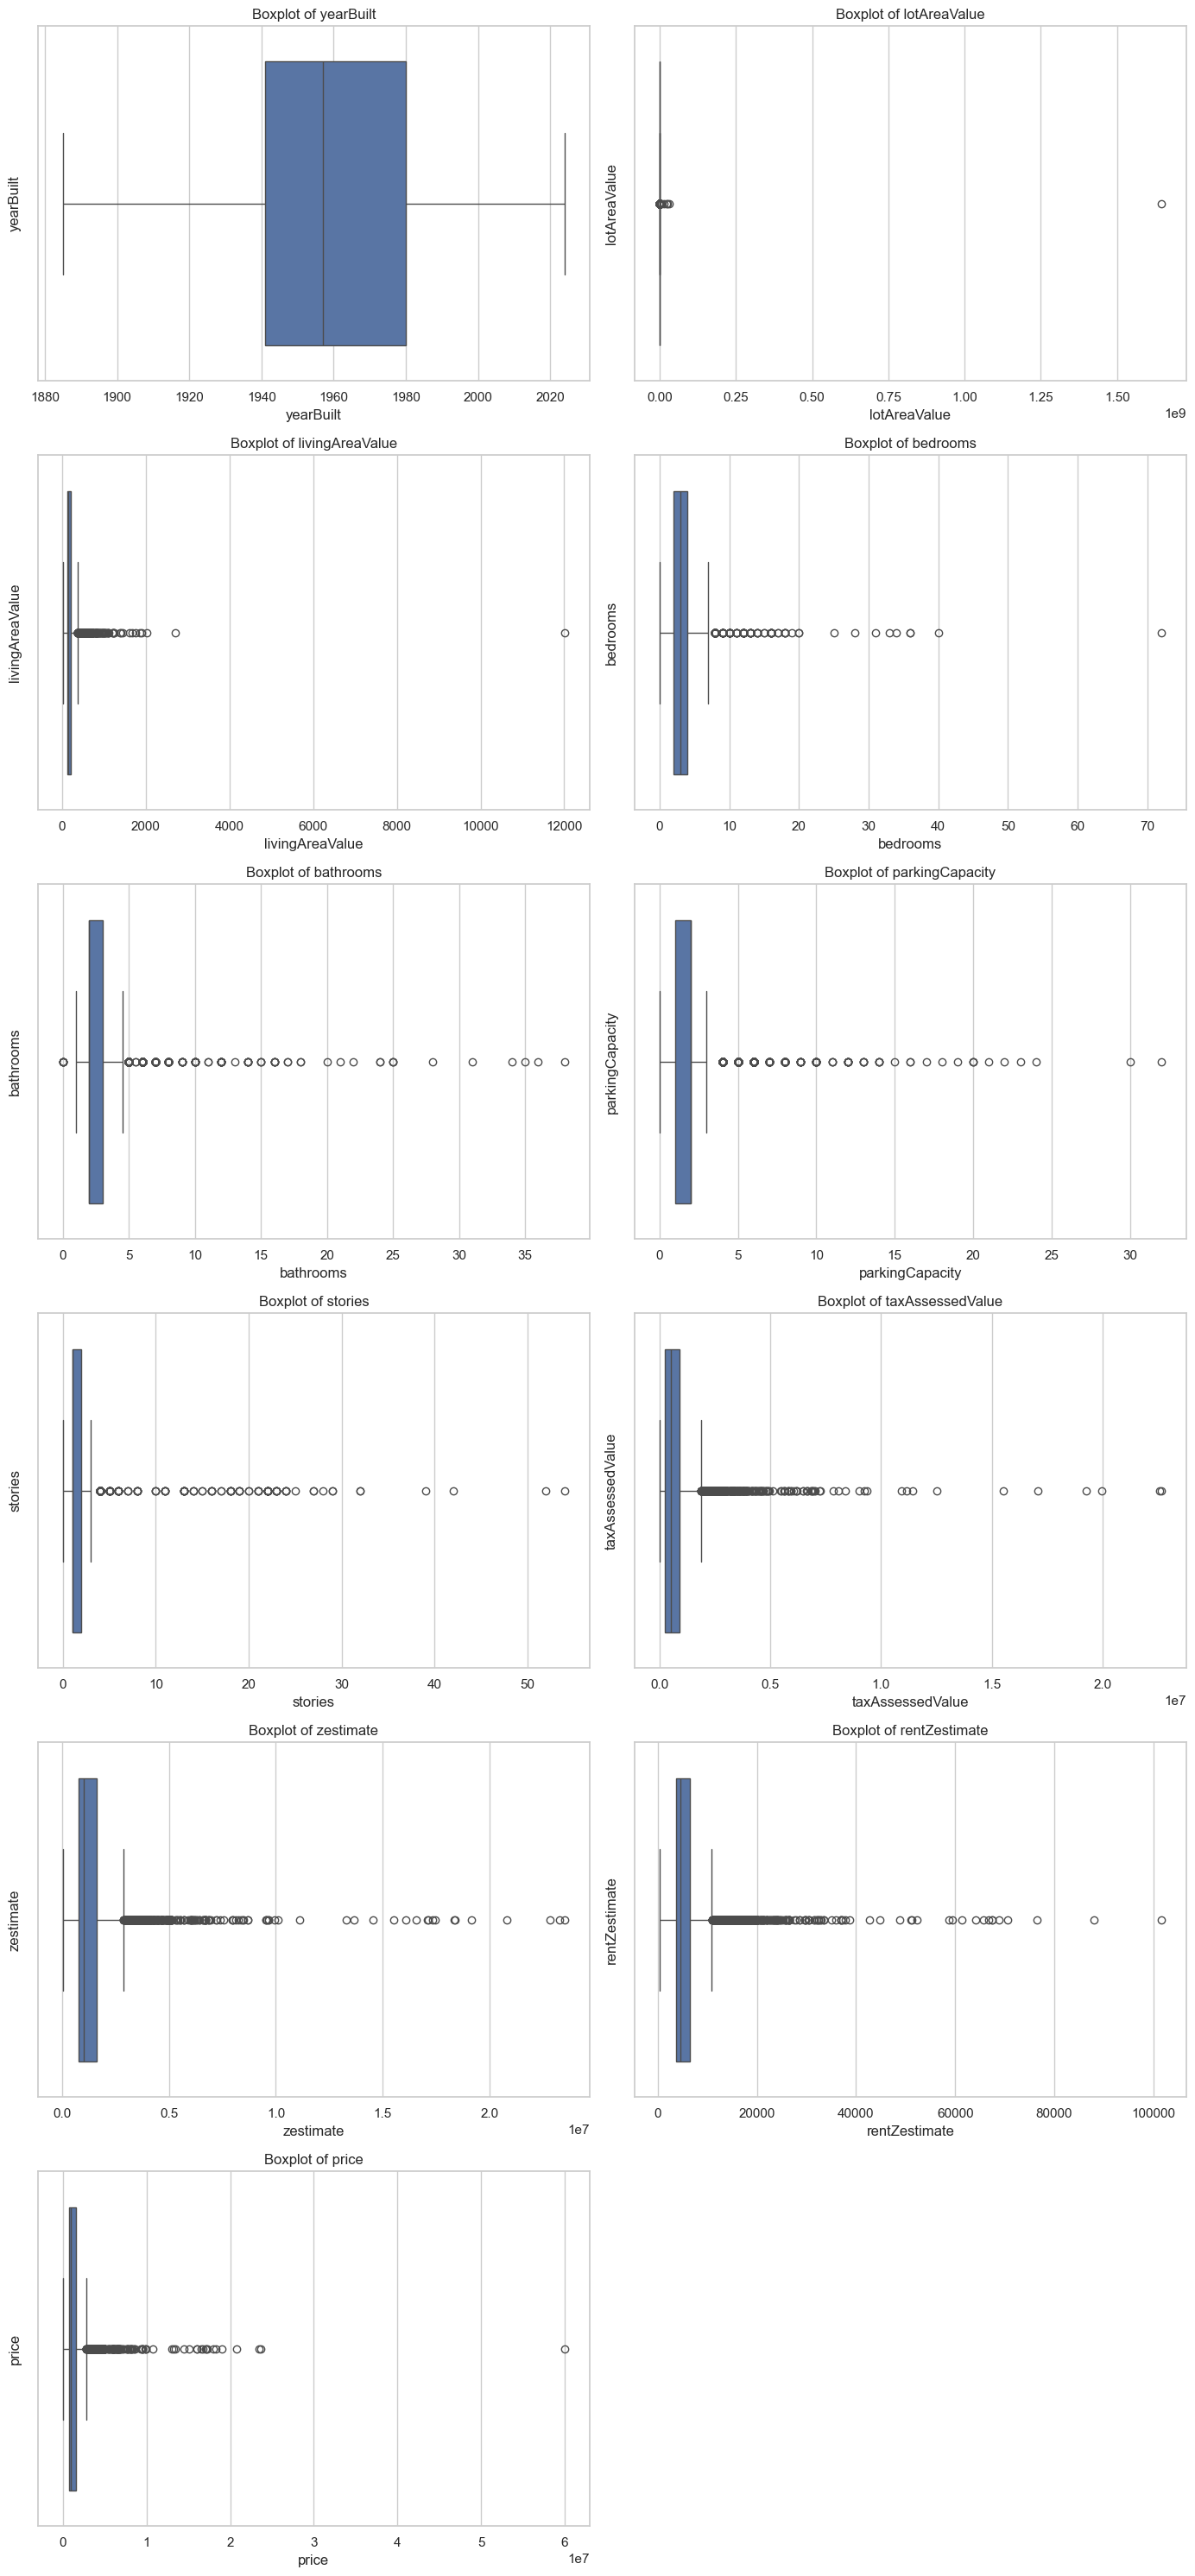

In [145]:
num_cols = 2
num_rows = int(np.ceil(num_features / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7 * num_cols, 5 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_ylabel(feature)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

From the boxplots we can see that most of our features have outliers with huge values! so in order to get a better understanding of other values we visualize the histograms of the features without the outliers.

First we write a function named `show_outliers` which return the dataframe containing the rows that are considered as outliers for a given feature. The method is based on the IQR method which is defined as the difference between the third quartile and the first quartile. The rows that have values outside the range of $[Q1 - 1.5 \times IQR, Q3 + 1.5 \times IQR]$ are considered as outliers.

In [146]:
def show_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

Now we plot the histograms of the features without the outliers:

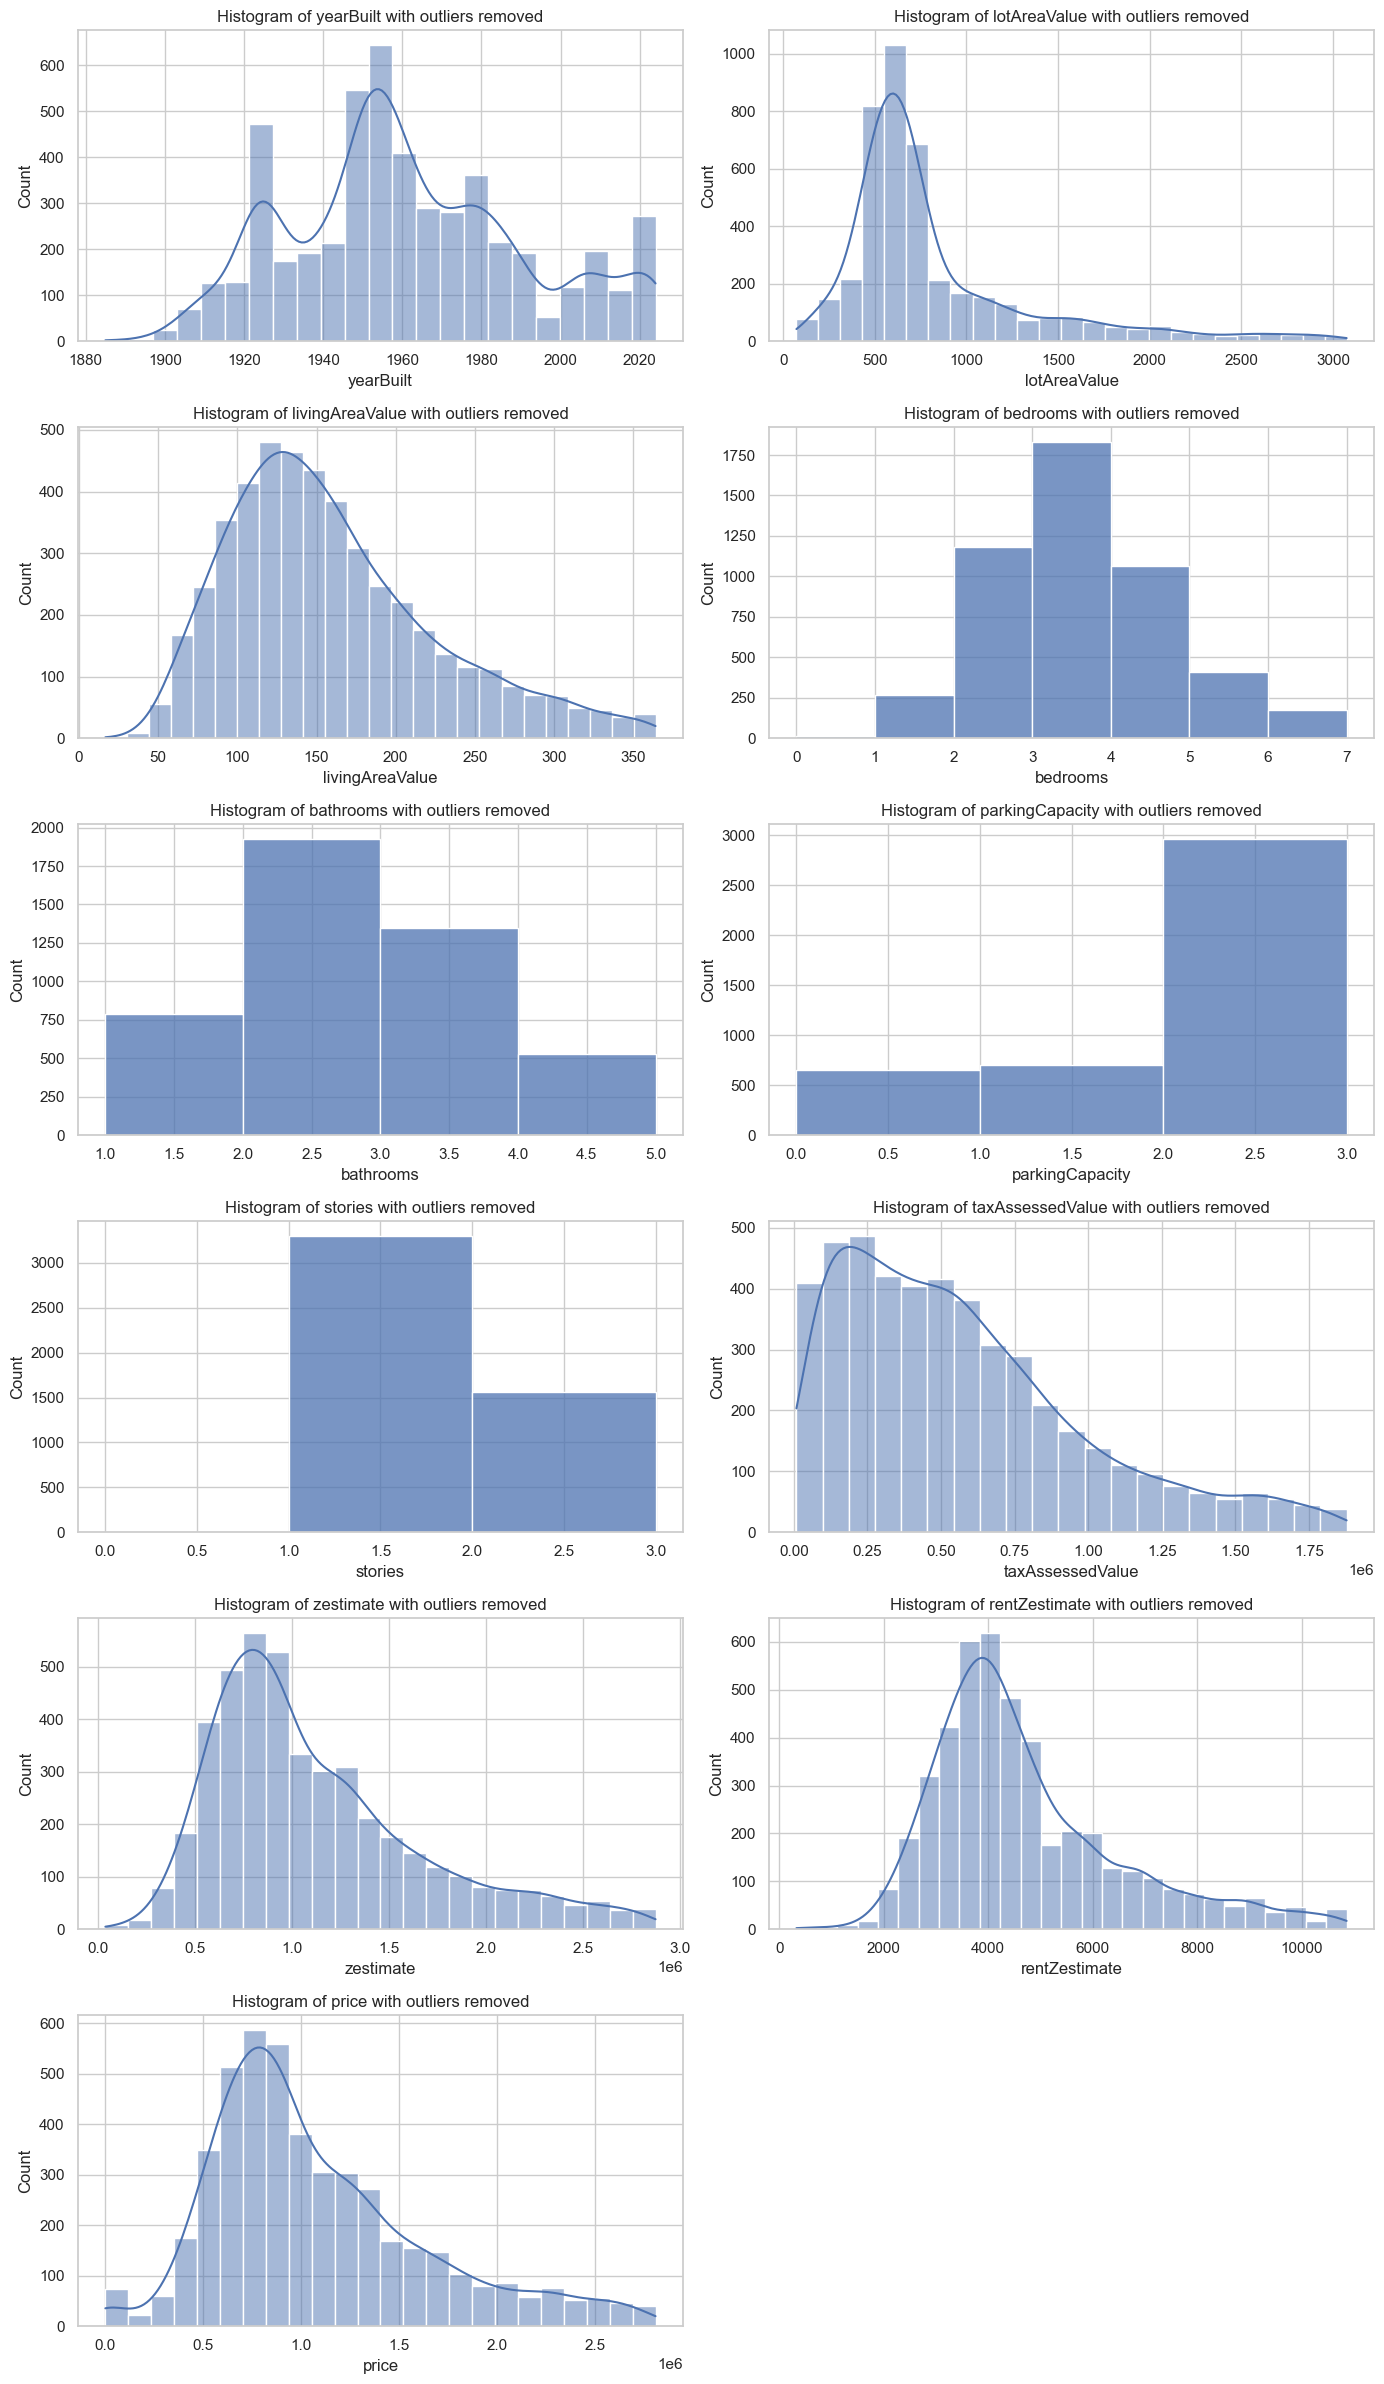

In [147]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7 * num_cols, 4 * num_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    outliers = show_outliers(df, feature)
    df_no_outliers = df.drop(outliers.index)
    data = df_no_outliers[feature]
    if feature in ["bedrooms", "bathrooms", "stories", "parkingCapacity"]:
        bins = range(math.ceil(min(df_no_outliers[feature])), math.ceil(max(df_no_outliers[feature])) + 1)
        sns.histplot(data, bins=bins, kde=False, ax=axes[i])
    else:
        sns.histplot(data, bins=calc_num_of_bins_scott_rule(data), kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature} with outliers removed')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

Now we analyze the distributions of the features without the outliers:

* `yearBuilt`: We didn't have any outliers for this feature. The histogram has a peak between 1940 and 1960. it has a logical reason because after the world war II, Los Angeles began to grow rapidly and many new houses were built in that period.(see [here](https://en.wikipedia.org/wiki/History_of_Los_Angeles#Postwar:_Baby_boomers)) and in the second half of the 20th century, it began to reduce and the number of new houses built decreased.

* `lotAreaValue`: We can see that most of the houses have a lot area between 500 and 1000 square meters. The distribution is right-skewed and we have a few houses with high lot areas.

* `livingAreaValue`: The distribution is less skewed than the lot area but it's still right-skewed. Most of the houses have a living area between 100 and 200 square meters.

* `bedrooms`:  We can infer that most of the houses have 2 to 4 bedrooms.

* `bathrooms`: Most of the houses have 2 to 3 bathrooms.

* `parkingCapacity`: Most of the houses have 3 parking spaces and we also have a noticeable number of houses with no parking spaces at all!

* `stories`: Most of the houses have 1 or 2 stories.

* `taxAssessedValue`: taxAssessedValue is the value of the house that is right-skewed and the distribution looks uniform until 750000 and then it starts to decrease.

* `zestimate`, `rentZestimate`, `price`: These three features have a similar distribution(which is expected because they are highly correlated). the distribution is right-skewed and it seems that most of the houses have a price between 600000 and 1200000.

### Handling Outliers

Now that we found that we have some effective outliers in our data, we check each feature's outliers specifically and decide how we should handle them.

First we write two functions to show the box plot and hist plot of a feature in the dataset. The first function is `show_boxplot` and the second one is `show_histplot`.

In [148]:
import math 

def show_boxplot(df, feature):
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)
    plt.show()
    
def show_hist(df, feature, discrete = False, bins_alg = calc_num_of_bins_sturges_rule):
    if discrete:
        bins = range(math.ceil(min(df[feature])), math.ceil(max(df[feature])) + 1)
        sns.histplot(df[feature], bins=bins, kde=False)
        plt.xticks(bins)
    else:
        bins = bins_alg(df[feature])
        sns.histplot(df[feature], bins=bins, kde=True)
    
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

#### LotAreaValue

First we check the box plot with outliers:

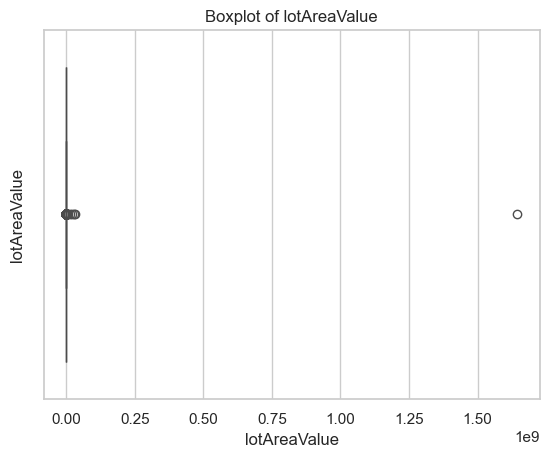

In [149]:
show_boxplot(df, 'lotAreaValue')

We can see that we have a lot area > 10^9 square meters which is 1000 square kilometers! Los angeles has a total area of 1300 square kilometers so it's impossible to have a house with a lot area of 1000 square kilometers! so we remove this row.

In [150]:
df[df['lotAreaValue'] > 1e9]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,rentZestimate,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView
106,91316,5460 White Oak Ave UNIT A214,CONDO,1971,1.644773e+09,91.97397,2,2.0,3.0,['Wood'],...,2498.0,"[('2008-04-24', 210000), ('2007-09-18', 319000...",270000,2,1,1,0,0,1,1


In [151]:
df = df[df['lotAreaValue'] < 1e9]

We check the box plot again:

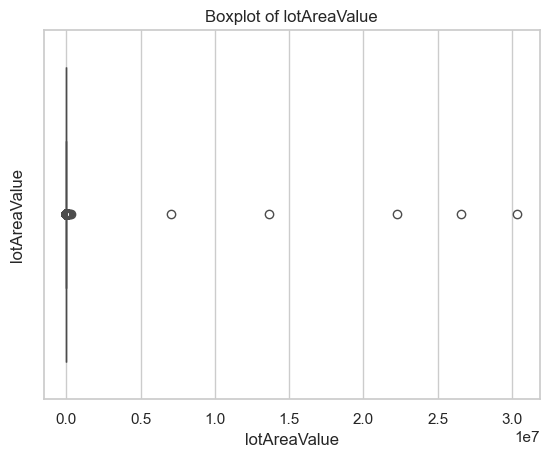

In [152]:
show_boxplot(df, 'lotAreaValue')

We can see that we have some rows with lot area > 10^6 square meters which is 1 square kilometer! We also remove these rows as they are not logical.(We checked those data in Zillow again and the lot area didn't make sense.)

In [153]:
df[df['lotAreaValue'] > 1e6]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,rentZestimate,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView
21,91335,7317 White Oak Ave,SINGLE_FAMILY,1951,22257730.00,47.566336,2,1.0,1.0,[],...,2500.0,[],2500,0,0,0,0,0,0,0
44,91345,14377 Germain St,SINGLE_FAMILY,1955,30351450.00,164.066698,3,2.0,1.0,['Wood'],...,3999.0,"[('2022-02-15', 840000), ('2010-12-01', 339500...",4000,1,1,1,0,0,0,0
1137,90002,9614 Grape St,SINGLE_FAMILY,2024,13658152.50,123.096475,4,3.0,1.0,[],...,3640.0,"[('2022-12-02', 435000), ('2022-09-14', 359803)]",690000,2,1,1,0,0,0,1
3331,90732,2501 Bowfin Ave,SINGLE_FAMILY,1954,26600010.78,138.611276,3,2.0,1.0,[],...,4500.0,"[('2020-05-18', 805000), ('1998-08-28', 329000)]",1280000,2,1,0,1,0,0,1
3800,90024,10727 Wilshire Blvd APT 403,CONDO,2001,7061770.70,162.115735,2,3.5,1.0,[],...,5937.0,"[('2011-09-16', 960000), ('2006-07-05', 135000...",1539473,0,1,1,0,0,0,0


In [154]:
df = df[df['lotAreaValue'] < 1e6]

We repeat the same process and delete the rows with lot area > 10^5 square meters:

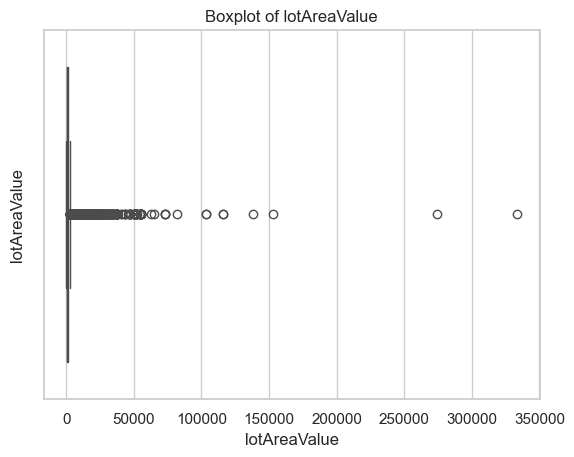

In [155]:
show_boxplot(df, 'lotAreaValue')

In [156]:
df[df["lotAreaValue"] > 1e5]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,rentZestimate,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView
95,91304,24425 Woolsey Canyon Rd SPACE 34,MANUFACTURED,1980,153218.571146,134.709350,2,2.0,1.0,['Laminate'],...,697.0,[],157000,2,1,1,0,0,1,0
764,90016,5187 Village Grn,CONDO,1942,273972.422000,85.099148,1,1.0,1.0,['Wood'],...,3028.0,"[('2023-11-03', 550000), ('2012-02-03', 170000)]",608500,1,0,1,0,0,0,1
1978,91342,12207 Via Santa Barbara,SINGLE_FAMILY,1999,116106.032144,173.821513,3,3.0,2.0,[],...,3716.0,"[('1999-08-19', 231000)]",860000,3,1,1,1,0,1,1
2192,91342,12101 Via Santa Barbara,SINGLE_FAMILY,1999,116106.032144,222.409782,4,4.0,2.0,[],...,4896.0,"[('2009-05-20', 425000), ('1999-11-24', 266000)]",905000,3,1,1,1,0,0,1
2205,91342,13173 La Tierra Way,SINGLE_FAMILY,2001,333546.248060,258.363243,3,3.0,2.0,[],...,4308.0,[],900000,2,1,1,0,0,0,1
3177,91307,23236 W Vail Dr,SINGLE_FAMILY,1987,138495.285094,183.018910,3,3.0,2.0,"['Carpet', 'Tile', 'Wood']",...,4270.0,"[('2017-10-17', 799000)]",1220000,3,1,1,1,1,1,1
3420,90077,10125 Hollow Glen Cir,CONDO,1970,103172.075832,198.533711,3,3.0,1.0,[],...,7500.0,[],1313000,0,1,1,0,0,0,0
4088,90077,10136 Hollow Glen Cir,SINGLE_FAMILY,1970,103171.458212,217.300117,4,3.0,2.0,"['Carpet', 'Wood', 'Wood', 'Marble', 'Stone']",...,8570.0,"[('1995-08-01', 420000)]",1786000,2,1,1,1,1,0,1


In [157]:
df = df[df["lotAreaValue"] < 1e5]

We check the box plot again and stop here because it doesn't seem that the other outliers are incorrect data.

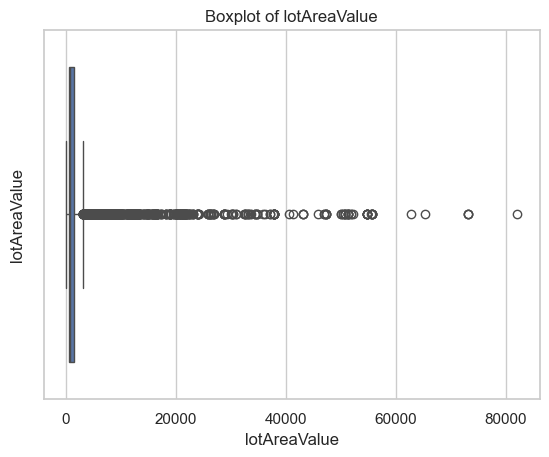

In [158]:
show_boxplot(df, 'lotAreaValue')

In [159]:
df[df["lotAreaValue"] > 60000]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,rentZestimate,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView
74,91304,8811 Canoga Ave SPACE 535,MANUFACTURED,1971,82058.180220,124.861632,2,2.0,1.0,[],...,330.0,[],85000,1,1,1,0,0,0,1
3630,90067,2393 Century Hl,TOWNHOUSE,1980,73170.061602,211.261422,2,3.0,3.0,"['Carpet', 'Vinyl', 'Marble', 'Tile', 'Other']",...,8870.0,[],1427000,3,1,1,1,0,0,1
3766,90067,2302 Century Hl,TOWNHOUSE,1980,73149.017930,291.158002,2,4.0,4.0,"['Carpet', 'Tile', 'Mixed', 'Parquet']",...,11791.0,"[('2023-07-06', 608397), ('2022-10-31', 60755)]",1525000,3,1,1,1,0,0,1
4187,90049,12377 Ridge Cir,SINGLE_FAMILY,1979,65212.720784,278.801903,2,3.0,2.0,"['Marble', 'Wood']",...,11442.0,"[('2013-03-22', 1230000), ('1999-08-31', 740000)]",1860000,2,1,1,1,0,0,1
4430,90067,2335 Century Hl,CONDO,1980,73149.017930,234.487172,2,4.0,1.0,['Wood'],...,8410.0,[],2250000,3,1,1,1,0,0,1
4907,91040,9540 Dale Ave,SINGLE_FAMILY,1952,62666.031786,468.416926,4,5.0,2.0,"['Laminate', 'Tile', 'Wood']",...,15641.0,"[('2019-01-31', 2650000), ('2011-12-29', 10000...",4000000,22,1,1,1,1,1,1


What we found out about the reason of some high lot areas is that condos and town houses count the whole area of the building as the lot area. So we can see that most of the outliers are condos and town houses.

In [160]:
lot_area_outliers = show_outliers(df, 'lotAreaValue')
lot_area_outliers["homeType"].value_counts()

homeType
CONDO            519
TOWNHOUSE        219
SINGLE_FAMILY     68
APARTMENT          6
MANUFACTURED       2
MULTI_FAMILY       1
Name: count, dtype: int64

In [161]:
#df.loc(df["homeType"].isin(['CONDO', 'APARTMENT', "TOWNHOUSE"]), 'lotAreaValue') = df["livingAreaValue"]
#df.drop(lot_area_outliers[~lot_area_outliers['homeType'].isin(['CONDO', 'APARTMENT', "TOWNHOUSE"])].index, inplace=True)

We add a new column `log_lotAreaValue` to the dataset which is the log of the `lotAreaValue`. The reason is that the distribution of the `lotAreaValue` is too right-skewed and by taking the log we can have a more normal distribution and later it'll be easier to work with this column in the statistical analysis and machine learning models.

In [162]:
df['log_lotAreaValue'] = np.log10(df['lotAreaValue'])

We check the box plot and histogram of the `log_lotAreaValue`. As we can see the distribution is more normal now and the number of outliers is reduced.

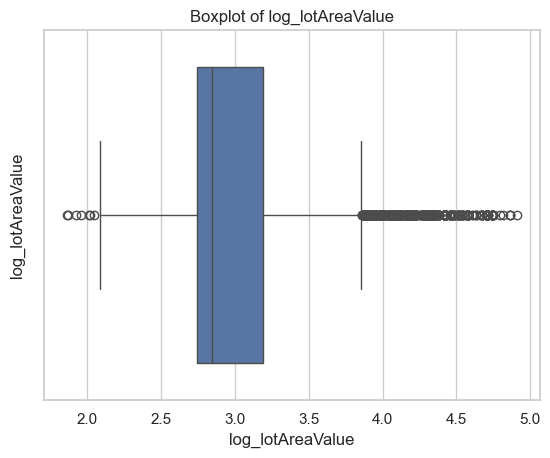

In [163]:
show_boxplot(df, 'log_lotAreaValue')

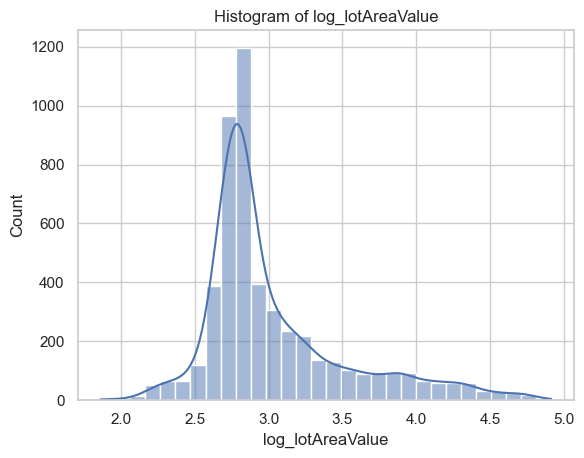

In [164]:
show_hist(df, 'log_lotAreaValue', bins_alg=calc_num_of_bins_scott_rule)

We check the skewness of the `log_lotAreaValue` and `lotAreaValue` and we can see that the skewness of the `log_lotAreaValue` is reduced significantly.(but it's still right-skewed)

- `Skewness`:
         $$\gamma = \frac{\sum_{i=1}^{n} (x_i - \bar{x})^3}{(n-1) \cdot s^3}$$


if the skewness value is near 0 then the distribution is approximately symmetric. If the skewness value is less than -1 or greater than 1 then the distribution is substantially skewed.

In [165]:
df["lotAreaValue"].skew()

5.2209326644764245

In [166]:
df["log_lotAreaValue"].skew()

1.4238809033026052

#### Living Area

For the living area, we repeat the same process. First we check the box plot with outliers and then remove some significant outliers and then add a new column `log_livingAreaValue` to the dataset which is the log of the `livingAreaValue`.

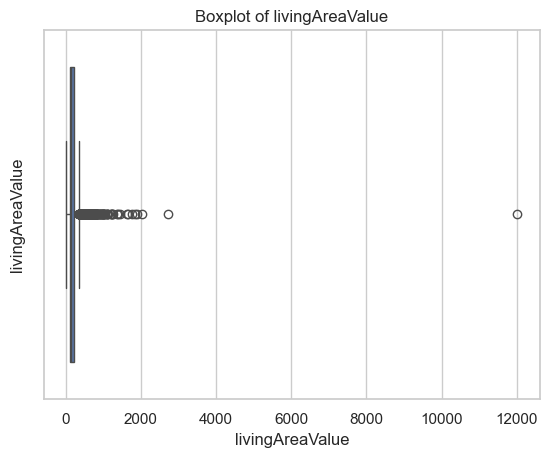

In [167]:
show_boxplot(df, 'livingAreaValue')

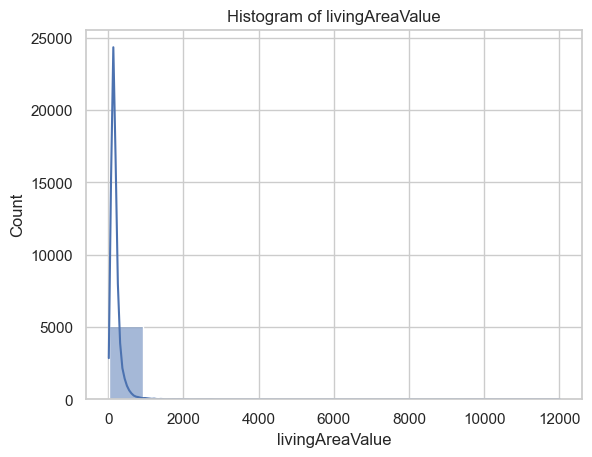

In [168]:
show_hist(df, 'livingAreaValue')

In [169]:
df[df['livingAreaValue'] > 1250]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,sold-history,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView,log_lotAreaValue
1674,91402,9146 Willis Ave,SINGLE_FAMILY,1976,1618.744000,1618.744000,4,2.0,1.0,[],...,"[('2009-05-22', 299500), ('2008-04-16', 540000...",800000,2,1,1,0,0,0,0,3.209178
4809,91605,13135 Vanowen St,MULTI_FAMILY,1960,1547.923950,1399.769501,33,25.0,2.0,[],...,[],3264000,14,1,1,0,0,0,0,3.189750
4846,90033,456 S Breed St,MULTI_FAMILY,1972,1751.871871,1751.871871,25,25.0,3.0,[],...,[],3600000,0,0,0,0,0,0,0,3.243502
4868,90210,9625 Oak Pass Rd,SINGLE_FAMILY,1974,1855.080624,1855.080624,4,4.0,2.0,"['Wood', 'Marble', 'Mixed', 'Tile', 'Cement', ...",...,"[('2018-08-09', 9000), ('2015-12-08', 1900000)...",3607500,4,1,1,1,1,1,1,3.268363
4961,90006,1029 Elden Ave,MULTI_FAMILY,1991,2024.263467,2024.263467,36,35.0,3.0,"['Laminate', 'Carpet']",...,[],4600000,32,1,1,0,0,0,0,3.306267
4980,90003,5869-5875 S San Pedro St,MULTI_FAMILY,2023,1667.330141,1667.330141,36,28.0,3.0,['Wood'],...,[],4800000,8,1,1,0,0,0,1,3.222022
5034,90034,10915 Rose Ave,MULTI_FAMILY,1971,1899.866350,1899.866350,31,31.0,1.0,[],...,[],4975000,0,1,0,0,0,0,0,3.278723
5060,90210,2859 Coldwater Canyon Dr,SINGLE_FAMILY,1959,12009.866422,12009.866422,7,6.0,2.0,['Other'],...,"[('2022-01-31', 11200000), ('2016-01-15', 1221...",7800000,20,1,1,1,0,0,1,4.079538
5069,91436,15824 Valley Vista Blvd,SINGLE_FAMILY,2024,1442.300904,1442.300904,5,7.0,2.0,['Wood'],...,"[('2022-06-30', 2850000), ('1996-09-13', 830000)]",8000000,3,1,1,1,0,0,1,3.159056
5085,90004,4804 Oakwood Ave,APARTMENT,2022,2709.608898,2709.608898,6,4.0,1.0,[],...,[],13450000,0,1,0,0,0,0,0,3.432907


In [170]:
df = df[df["livingAreaValue"] < 1250]

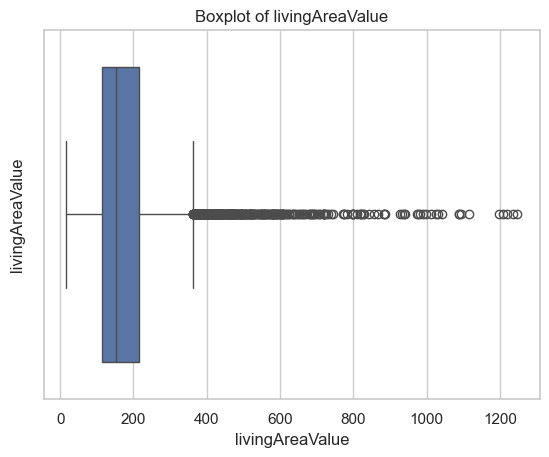

In [171]:
show_boxplot(df, 'livingAreaValue')

As you can see the living area has a much better distribution after removing the outliers.

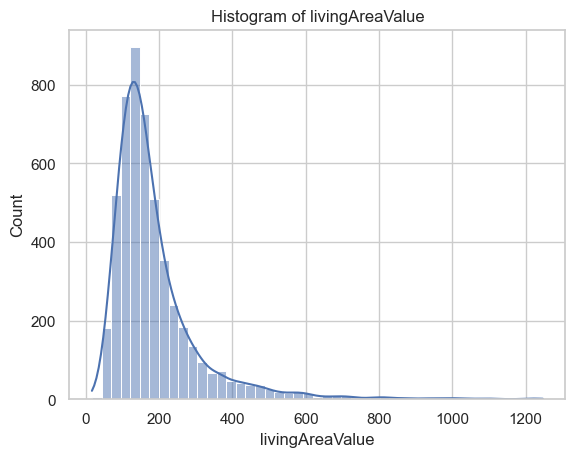

In [172]:
show_hist(df, 'livingAreaValue', bins_alg=calc_num_of_bins_scott_rule)

`log_livingAreaValue` is much less skewed and is more normal than the `livingAreaValue`.

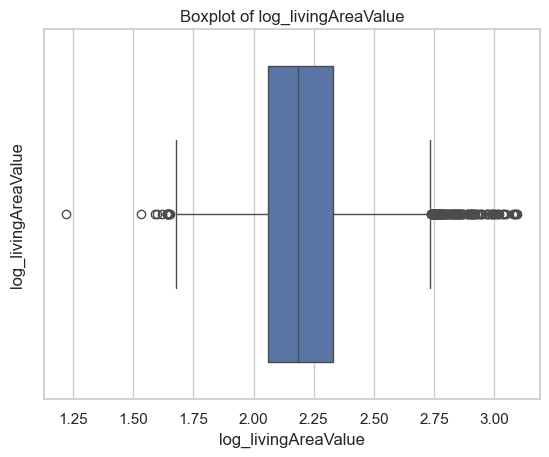

In [173]:
df["log_livingAreaValue"] = np.log10(df["livingAreaValue"])

show_boxplot(df, 'log_livingAreaValue')

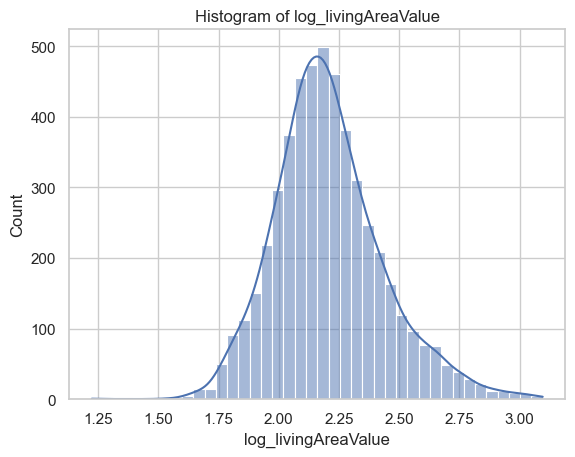

In [174]:
show_hist(df, 'log_livingAreaValue', bins_alg=calc_num_of_bins_scott_rule)

In [175]:
df["livingAreaValue"].skew()

3.048128342469588

In [176]:
df["log_livingAreaValue"].skew()

0.5788024874027203

We also plot the QQ plot of the `log_livingAreaValue` to see how close it is to the normal distribution:

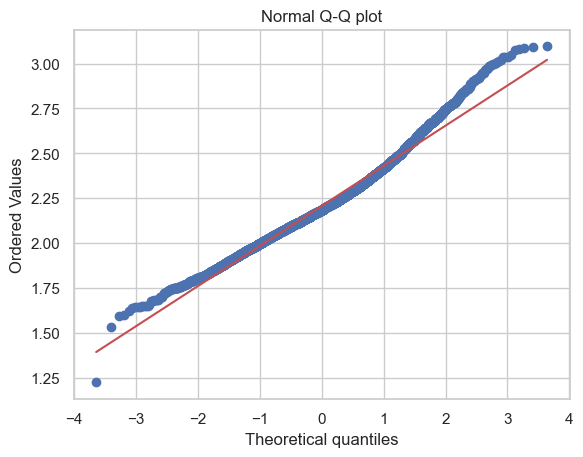

In [177]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df['log_livingAreaValue'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

#### bedrooms

For bedrooms we found out that the houses with strangely high number of bedrooms are multi-family houses and we can't say that they are outliers because they are not incorrect data. So we don't remove any rows for this feature.

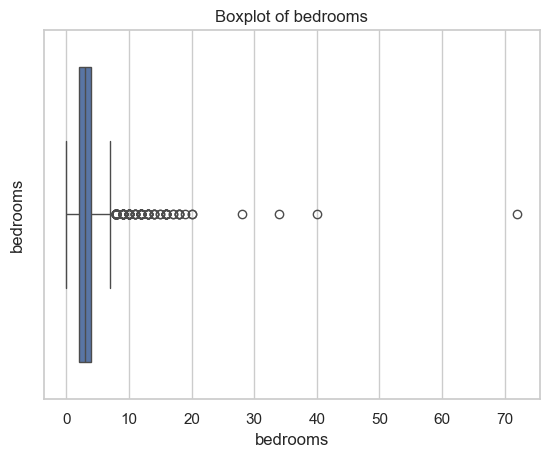

In [178]:
show_boxplot(df, 'bedrooms')

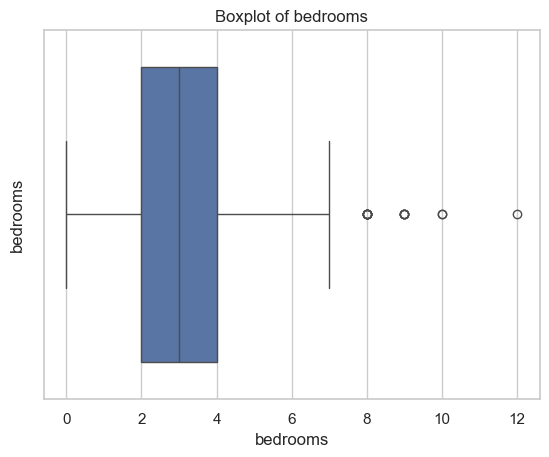

In [179]:
show_boxplot(df[df["homeType"] != "MULTI_FAMILY"], 'bedrooms')

In [180]:
df[df["homeType"] != "MULTI_FAMILY"]["bedrooms"].value_counts()

bedrooms
3     1793
2     1151
4      960
5      352
1      261
6       85
7       19
0       16
8        8
9        5
10       2
12       1
Name: count, dtype: int64

If we plot the number of bedrooms for houses that are not multi-family, we can see that the outliers are removed and the distribution is more normal.

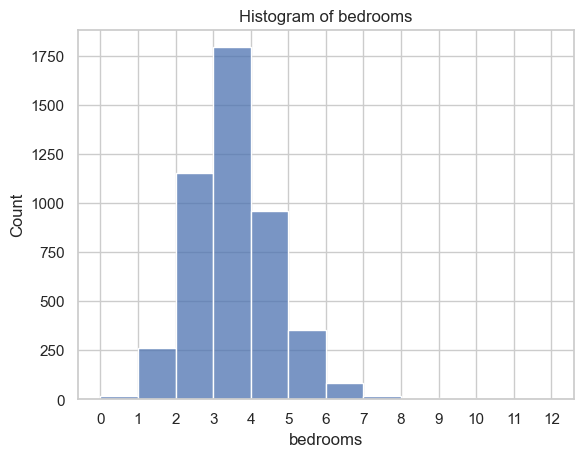

In [181]:
show_hist(df[df["homeType"] != "MULTI_FAMILY"], 'bedrooms', discrete=True)

#### bathrooms

The same thing goes for the bathrooms. We have some houses with a high number of bathrooms but they are not incorrect data as they are for multi-family houses. So we don't remove any rows for this feature.

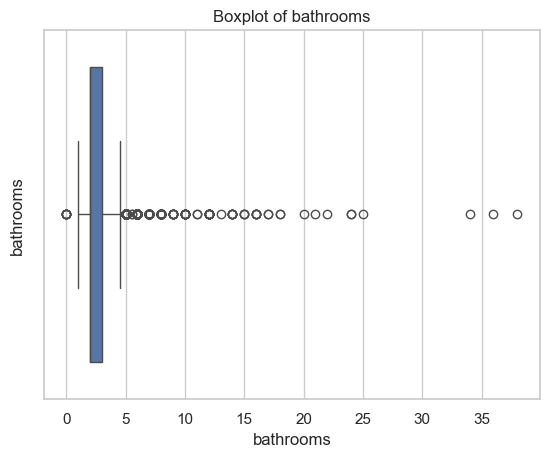

In [182]:
show_boxplot(df, 'bathrooms')

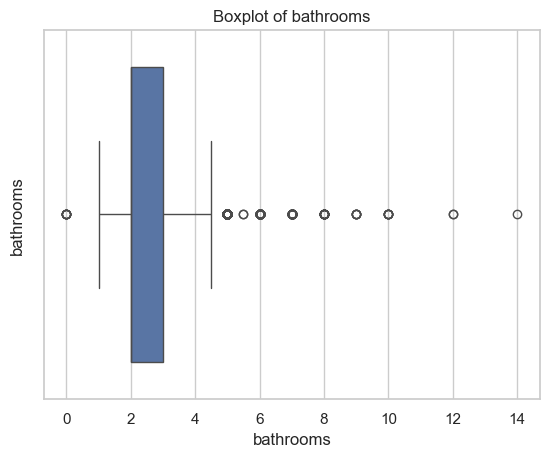

In [183]:
show_boxplot(df[df["homeType"] != "MULTI_FAMILY"], 'bathrooms')

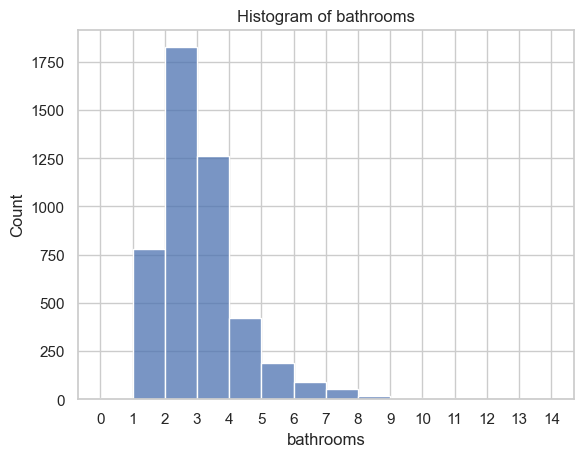

In [184]:
show_hist(df[df["homeType"] != "MULTI_FAMILY"], 'bathrooms', discrete=True)

#### Parking Capacity

We also don't remove any outliers of the parking capacity because they don't seem to be incorrect data.

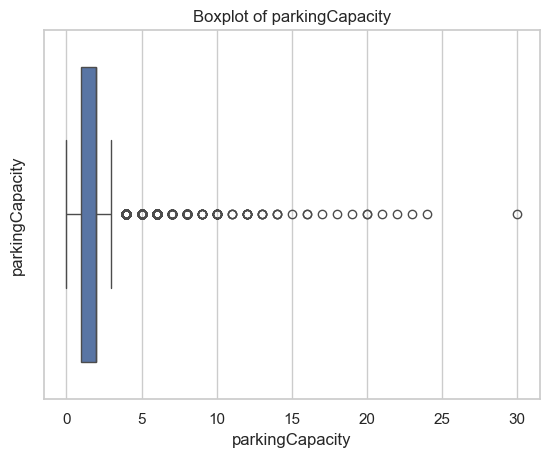

In [185]:
show_boxplot(df, 'parkingCapacity')

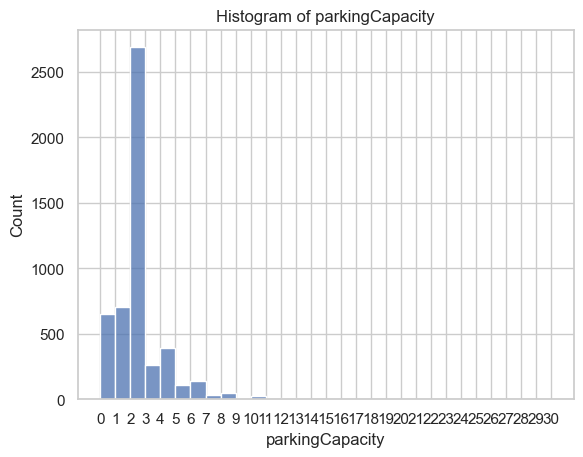

In [186]:
show_hist(df, 'parkingCapacity', discrete=True)

In [187]:
df[df["parkingCapacity"] > 15]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView,log_lotAreaValue,log_livingAreaValue
431,90004,532 N Rossmore Ave APT 409,CONDO,1972,1737.721684,65.125003,1,1.0,4.0,"['Carpet', 'Tile']",...,499500,21,1,1,0,0,0,1,3.239980,1.813748
1729,91331,13960 Filmore St,SINGLE_FAMILY,1929,1016.824672,98.105568,3,2.0,1.0,[],...,810000,30,1,0,1,0,0,1,3.007246,1.991694
4374,90065,3429 Andrita St,MULTI_FAMILY,1962,1257.764088,800.266442,14,17.0,3.0,[],...,2175000,23,1,1,0,0,0,0,3.099599,2.903235
4648,90731,970-964 W Santa Cruz St,MULTI_FAMILY,1979,1207.554781,718.697608,16,10.0,2.0,[],...,2760000,18,0,1,0,0,0,0,3.081907,2.856546
4659,91606,11848 Oxnard St,MULTI_FAMILY,1954,1757.146612,941.293196,16,14.0,3.0,"['Mixed', 'Laminate', 'Wood', 'Tile', 'Linoleu...",...,2750000,17,1,1,1,0,0,0,3.244808,2.973725
4676,90026,275 Lucas Ave,MULTI_FAMILY,1964,1129.237449,999.450474,8,22.0,2.0,[],...,2908000,24,0,0,0,0,0,0,3.052785,2.999761
4710,91325,17302 Lassen St,SINGLE_FAMILY,1916,5880.492266,1024.627187,12,10.0,1.0,"['Vinyl', 'Wood']",...,3000000,20,1,1,1,1,0,1,3.769414,3.010566
4907,91040,9540 Dale Ave,SINGLE_FAMILY,1952,62666.031786,468.416926,4,5.0,2.0,"['Laminate', 'Tile', 'Wood']",...,4000000,22,1,1,1,1,1,1,4.797032,2.670633
4946,91601,10916 Peach Grove St,MULTI_FAMILY,1986,926.242910,926.242910,20,20.0,3.0,[],...,4057725,19,1,1,0,0,0,0,2.966725,2.966725
5001,90025,1218 McClellan Dr,MULTI_FAMILY,1972,1092.353474,1092.353474,16,16.0,2.0,[],...,4965000,16,0,0,0,0,0,0,3.038363,3.038363


#### stories

We found out that the outliers in the stories are all condos and town houses and they probably set the number of all the stories of the building but each unit is only one story. So we set the number of stories of these houses to 1.

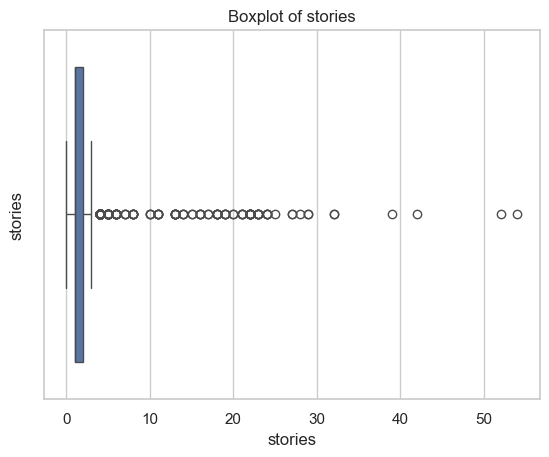

In [188]:
show_boxplot(df, 'stories')

In [189]:
df[df["stories"] > 25]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView,log_lotAreaValue,log_livingAreaValue
321,90012,800 W 1st St APT 2202,CONDO,1968,9865.839994,70.792086,1,1.0,32.0,"['Laminate', 'Wood']",...,460000,1,1,1,0,0,0,1,3.994134,1.849985
1456,90012,800 W 1st St APT 1903,CONDO,1968,9865.839994,114.642302,2,2.0,32.0,['Laminate'],...,753000,1,1,1,0,0,1,1,3.994134,2.059345
2798,90017,1100 Wilshire Blvd APT 2102,CONDO,1986,2518.360978,148.644800,2,2.0,39.0,"['Wood', 'Tile']",...,1075000,2,1,1,1,0,0,1,3.401118,2.172150
4049,90067,2220 Avenue Of The Stars UNIT 2506,CONDO,1964,16523.734066,151.803502,2,2.0,28.0,['Tile'],...,1750000,2,1,1,0,0,1,1,4.218108,2.181282
4052,90024,10490 Wilshire Blvd APT 406,CONDO,1989,7873.975502,257.898728,2,3.0,29.0,"['Carpet', 'Tile', 'Wood']",...,1750026,2,1,1,1,0,0,1,3.896194,2.411449
4178,90067,2222 Avenue Of The Stars UNIT 504,CONDO,1964,16519.282520,199.276935,3,3.0,27.0,"['Wood', 'Tile', 'Carpet']",...,1895000,2,1,1,0,0,0,1,4.217991,2.299457
4437,90015,900 W Olympic Blvd UNIT 39J,CONDO,2010,37105.254654,202.528540,2,3.0,52.0,"['Wood', 'Mixed']",...,2315000,2,1,1,0,0,0,1,4.569435,2.306486
4510,90015,900 W Olympic Blvd UNIT 47C,CONDO,2010,37094.328132,242.105218,3,4.0,54.0,"['Wood', 'Marble', 'Carpet', 'Stone', 'Wood']",...,2500000,2,1,1,1,0,0,1,4.569308,2.384004
4590,90024,10580 Wilshire Blvd APT 12SW,CONDO,1991,4283.196624,256.133571,2,3.0,27.0,['Mixed'],...,2500000,2,1,1,0,0,0,1,3.631768,2.408467
4860,90067,1 W Century Dr UNIT 7C,CONDO,2010,14992.806928,258.270340,2,3.0,42.0,"['Wood', 'Marble']",...,3700000,2,1,1,1,0,0,1,4.175883,2.412075


In [190]:
df[df["stories"] > 5]["homeType"].value_counts()

homeType
CONDO        96
TOWNHOUSE     1
Name: count, dtype: int64

In [191]:
df[df['homeType'] == 'CONDO']['stories'].value_counts().head()

stories
1.0    437
2.0    138
3.0    136
4.0     99
5.0     27
Name: count, dtype: int64

In [192]:
df.loc[df['homeType'] == 'CONDO', 'stories'] = 1

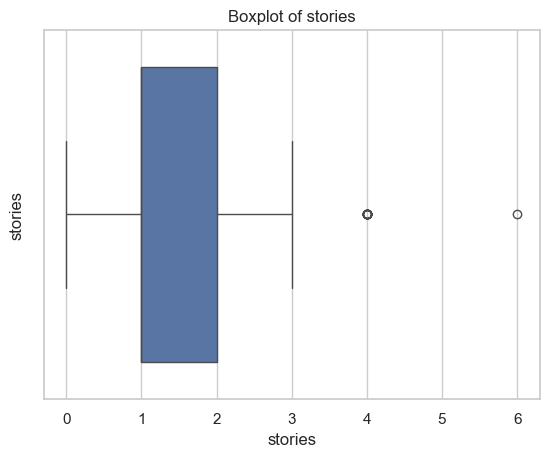

In [193]:
show_boxplot(df, 'stories')

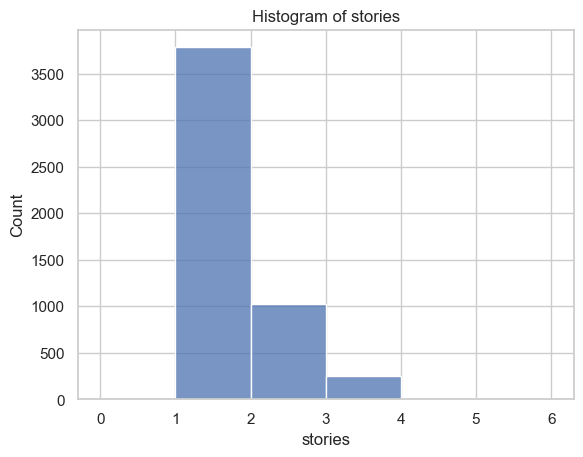

In [194]:
show_hist(df, 'stories', discrete=True)

In [195]:
df[df["stories"] > 4]

,zipcode,streetAddress,homeType,yearBuilt,lotAreaValue,livingAreaValue,bedrooms,bathrooms,stories,flooring,...,price,parkingCapacity,hasCooling,hasHeating,hasFireplace,hasPrivatePool,hasSpa,hasView,log_lotAreaValue,log_livingAreaValue
1051,90024,1440 Veteran Ave APT 601,TOWNHOUSE,1972,8999.002582,74.136594,2,1.0,6.0,"['Carpet', 'Tile', 'Wood']",...,670000,1,1,1,0,0,0,1,3.954194,1.870033


We save the data before removing the price outliers as we may have some works with price outliers in the future!

In [196]:
df.to_csv('data_with_price_outliers.csv', index=False)

#### price


We check the box plot of the price and we see that we have houses with much higher prices than the others. We use the same method as before and create a new column `log_price` which is the log of the `price`.

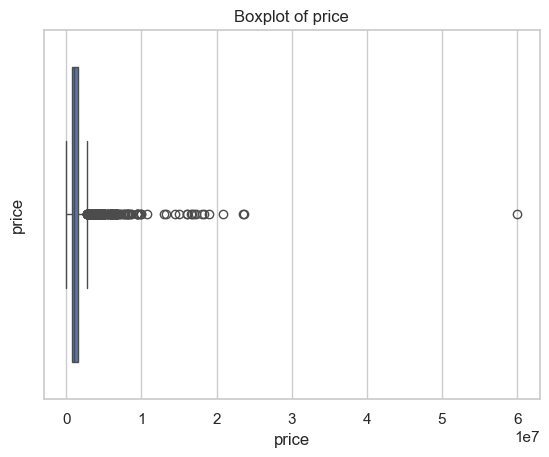

In [197]:
show_boxplot(df, 'price')

We can see that the box plot of the `log_price` is much better than the `price`. Because now we can also detect the outliers from the left side of the box plot.(the houses with lower prices)

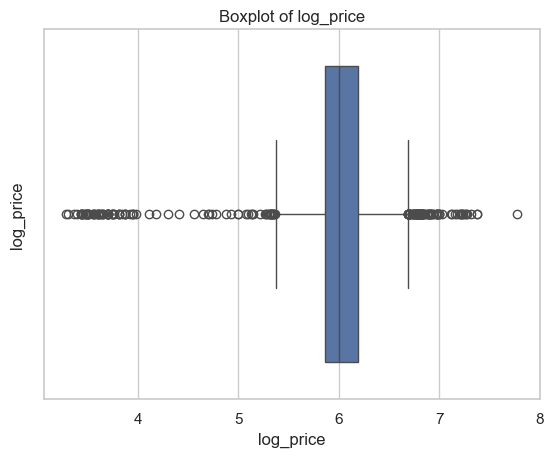

In [198]:
df["log_price"] = np.log10(df['price'])
show_boxplot(df, 'log_price')

Also the distribution of the `log_price` is much more normal than the `price`.

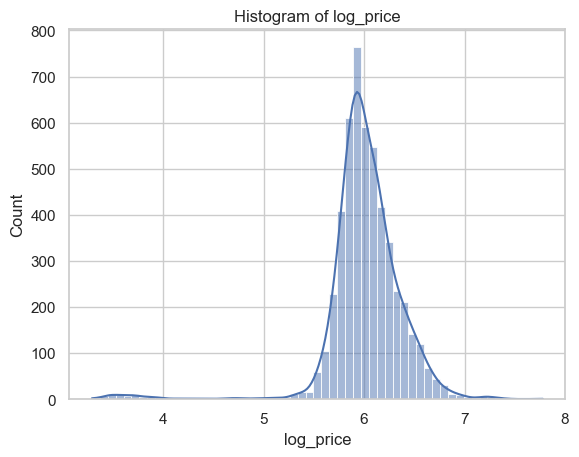

In [199]:
show_hist(df, 'log_price', bins_alg=calc_num_of_bins_scott_rule)

Now in order to remove the outliers, we check the zestimate(estimated price by Zillow) and the real price and remove those that the ratio of the price to the zestimate is less than 0.5 or greater than 2.(We reached this threshold gradually by checking the data and we found that this threshold is the best one.)

In [200]:
show_outliers(df, 'log_price')[["zestimate", "price"]]

,zestimate,price
0,701200.0,3050
1,734100.0,3100
2,464800.0,2800
3,759600.0,3600
4,498300.0,3100
...,...,...
5098,NaN,16000000
5099,13650900.0,13250000
5100,17094300.0,16750000
5101,13303200.0,12999000


In [201]:
df["zestimate/price"] = df["zestimate"] / df["price"]

In [202]:
df["zestimate/price"].describe()

count    4827.000000
mean        3.883203
std        26.268627
min         0.321809
25%         1.006095
50%         1.016375
75%         1.026667
max       409.863014
Name: zestimate/price, dtype: float64

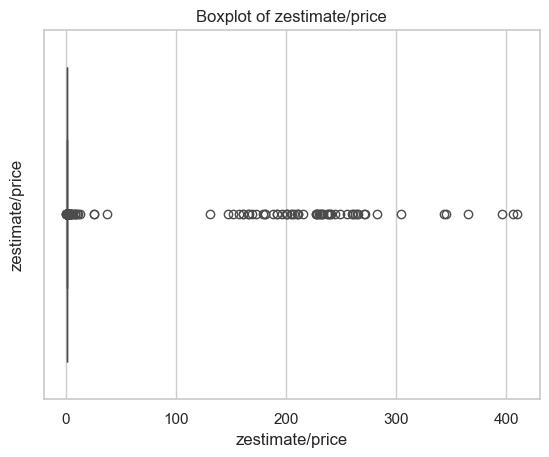

In [203]:
show_boxplot(df, 'zestimate/price')

In [204]:
df = df[(df["zestimate/price"] < 10) | (df["zestimate/price"].isna())]

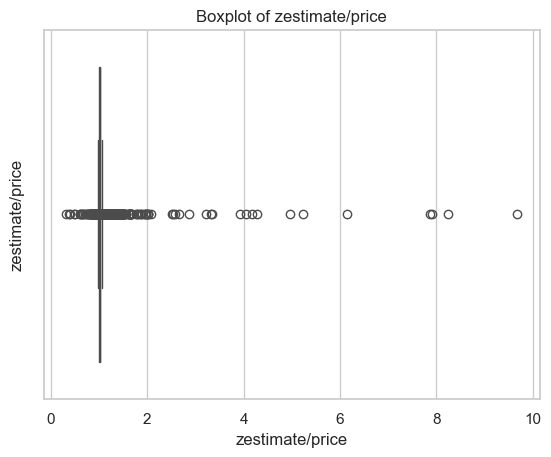

In [205]:
show_boxplot(df, 'zestimate/price')

In [206]:
df = df[(df["zestimate/price"] < 2) | (df["zestimate/price"].isna())]

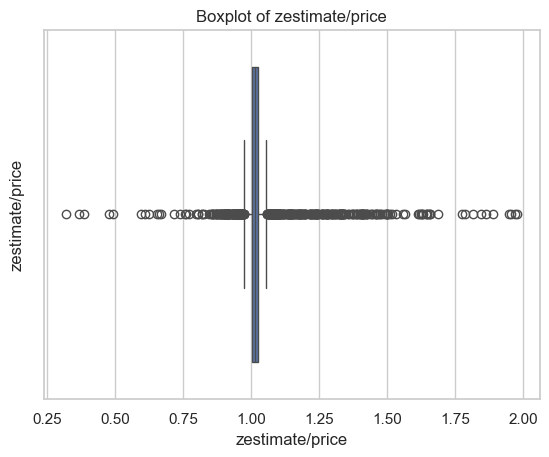

In [207]:
show_boxplot(df, 'zestimate/price')

In [208]:
df = df[(df["zestimate/price"] > 0.5) | (df["zestimate/price"].isna())]

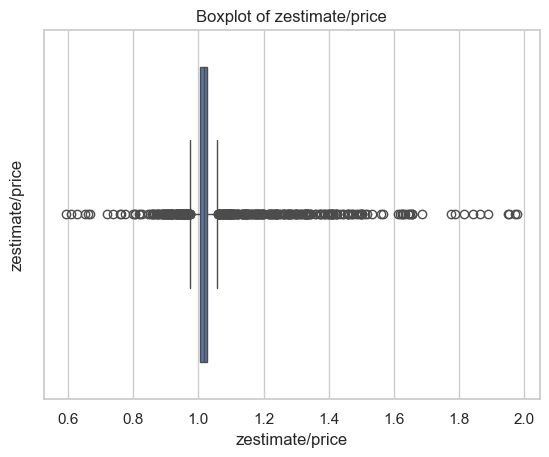

In [210]:
show_boxplot(df, 'zestimate/price')

Now we can see some of the outliers are removed using this method and now the distribution of the `log_price` is much better.

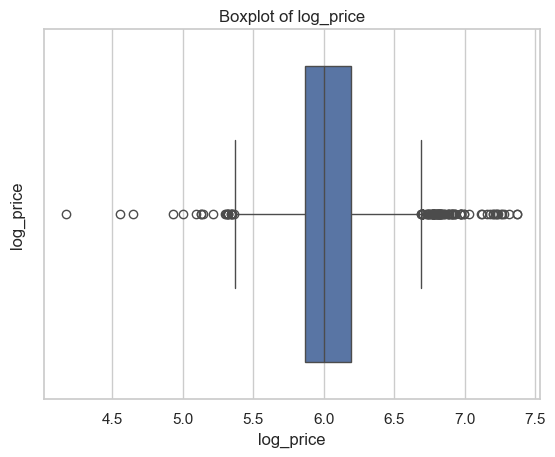

In [211]:
show_boxplot(df, "log_price")

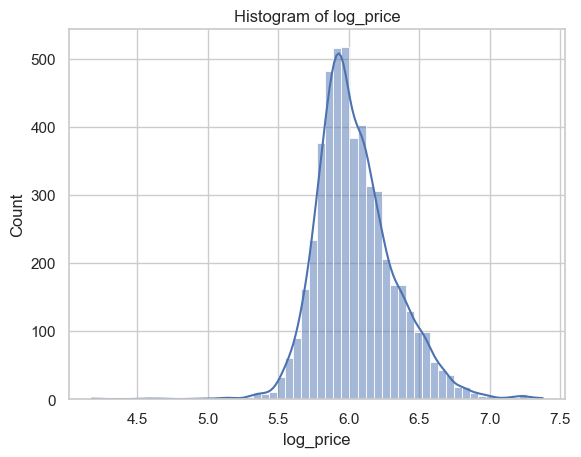

In [212]:
show_hist(df, "log_price", bins_alg=calc_num_of_bins_scott_rule)

We check the skewness and the QQ plot of the `log_price` to show how close it is to a normal distribution.

In [215]:
skewness = df["log_price"].skew()
print(f"Skewness: {skewness:.2f}")

Skewness: 0.58


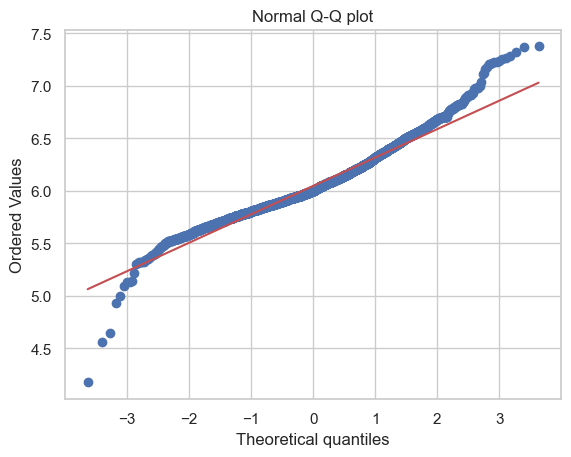

In [216]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df['log_price'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

Finally we check the distributions of price in different home types.

In [218]:
df["homeType"].value_counts()

homeType
SINGLE_FAMILY    3316
CONDO             915
MULTI_FAMILY      423
TOWNHOUSE         298
APARTMENT          17
MANUFACTURED       10
LOT                 7
Name: count, dtype: int64

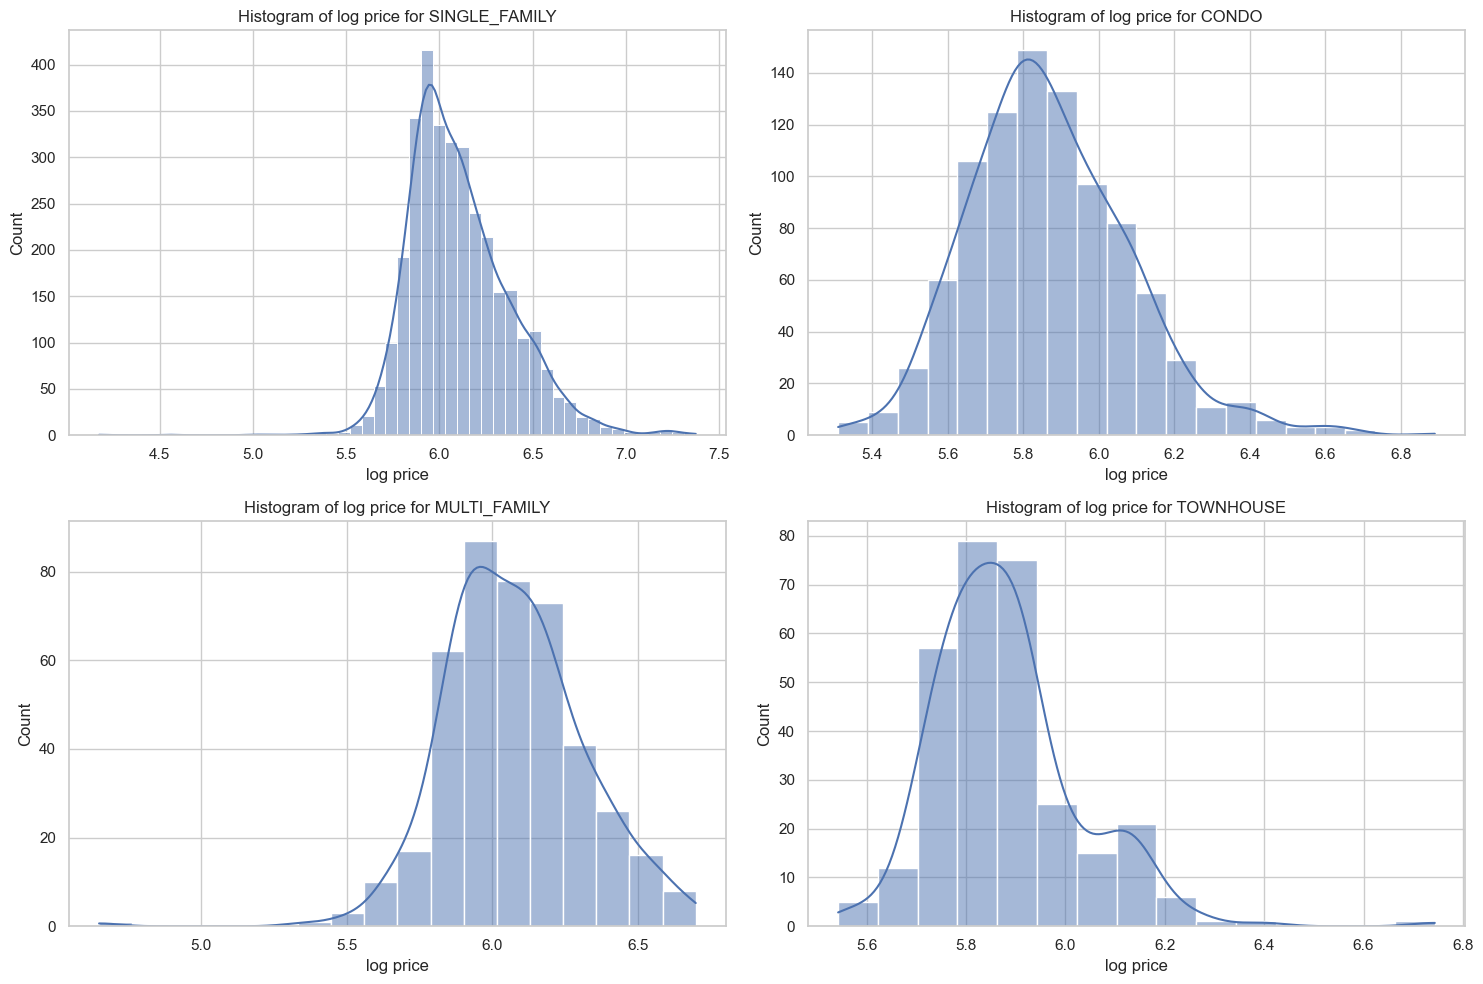

In [219]:
types = ["SINGLE_FAMILY", "CONDO", "MULTI_FAMILY", "TOWNHOUSE"]

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()
for i, home_type in enumerate(types):
    data = df[df["homeType"] == home_type]["log_price"]
    sns.histplot(data, bins=calc_num_of_bins_scott_rule(data), kde=True, ax=ax[i])
    ax[i].set_title(f'Histogram of log price for {home_type}')
    ax[i].set_xlabel('log price')
    ax[i].set_ylabel('Count')

plt.tight_layout()

As you can see the distributions are similar and we can also infer that the price of condos and town house is less than single family and multi-family houses.

#### tax assessed value

For tax assessed value we repeat the same process and create a new column `log_taxAssessedValue` which is the log of the `taxAssessedValue`.

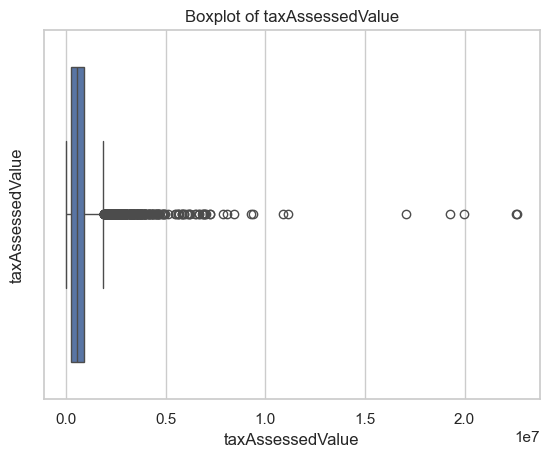

In [220]:
show_boxplot(df, 'taxAssessedValue')

In [221]:
df["log_taxAssessedValue"] = np.log10(df['taxAssessedValue'])

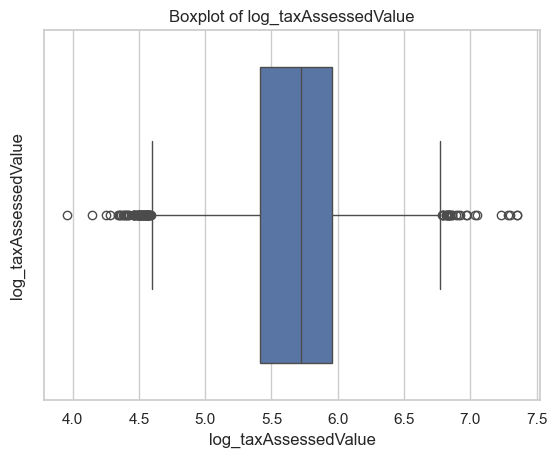

In [222]:
show_boxplot(df, 'log_taxAssessedValue')

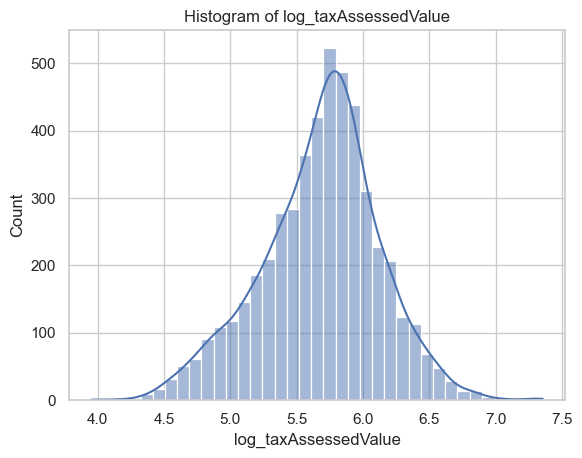

In [223]:
show_hist(df, 'log_taxAssessedValue', bins_alg=calc_num_of_bins_scott_rule)

Finally we save the data after removing the outliers and we are ready for the next steps.

In [227]:
df.drop(columns=["zestimate/price"], inplace=True)
df.to_csv('data_without_price_outliers.csv', index=False)